In [1]:
import spotipy
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
import spotify
import sqlite3
%load_ext autoreload
%autoreload 2

from config import (
    api_key_lastfm,
    client_secret_lastfm,
    client_id,
    client_secret,
    redirect_uri
)

In [ ]:
playlist_drill = '1z1tOO60TXJaLEfXb5Z1pw'
playlist_house = '1vIMNWoiysQgw4q13PErN4'
playlist_rap_us = '4OZ02mQrmS1LU8bkG09vq7'
playlist_afrobeat = '25Y75ozl2aI0NylFToefO5'
playlist_annees_80 = '0slE73JFtRr3F2KnfoWlbO'

playlist_ids = [playlist_drill, playlist_house, playlist_rap_us, playlist_afrobeat, playlist_annees_80]

In [2]:
def view_table(table_name='tracks_history', db_name='spotify_project.db'):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

In [3]:
dataset_list = []
playlist_names = ['playlist_drill', 'playlist_house', 'playlist_rap_us', 'playlist_afrobeat', 'playlist_annees_80']
for playlist_name in playlist_names:
    playlist = view_table(table_name=playlist_name)
    dataset_list.append(playlist)
dataset = pd.concat(dataset_list, axis=0, ignore_index=True)
dataset['release_date'] = pd.to_datetime(dataset['release_date'], errors='coerce')

In [4]:
dataset_vect = spotify.vectorize_recent_tracks(dataset, n_components=100, played_date=False)
dataset_vect

,popularity,duration,track_listeners,track_playcount,release_date,album_id,track_id,similar_artists_1,similar_artists_2,similar_artists_3,...,album_artists_id_91,album_artists_id_92,album_artists_id_93,album_artists_id_94,album_artists_id_95,album_artists_id_96,album_artists_id_97,album_artists_id_98,album_artists_id_99,album_artists_id_100
0,0,176.427,1519,11302,7805.0,178,647,-0.158630,-0.051699,-0.011674,...,0.002823,-0.005950,-0.001892,0.008596,0.006684,0.002757,-0.000309,-0.000946,0.000450,0.000321
1,37,478.693,7704,88497,7806.0,137,577,-0.159313,-0.063581,-0.017654,...,-0.005557,0.005084,0.004226,-0.008609,-0.001284,-0.004973,0.001132,0.003717,-0.001160,0.002235
2,25,305.600,3132,25189,6837.0,14,423,-0.137736,-0.030305,-0.003578,...,0.001705,-0.002129,-0.000907,0.002855,0.001568,0.001264,-0.000076,-0.000054,0.000497,0.000081
3,0,227.040,6829,62105,7769.0,284,5,-0.363088,-0.620236,-0.276777,...,0.001970,-0.004377,-0.001703,0.005798,0.002477,0.001995,-0.000036,-0.000145,0.000753,0.000234
4,45,170.106,21604,273035,7559.0,721,607,-0.363088,-0.620236,-0.276777,...,0.001740,-0.001049,-0.000409,0.001563,0.001534,0.000996,0.000145,0.000070,0.000129,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,26,209.562,1888,7319,-7884.0,616,845,-0.555690,1.479323,0.090315,...,0.001003,-0.001258,-0.000536,0.001685,0.000903,0.000747,-0.000047,-0.000029,0.000302,0.000048
889,40,196.640,49592,229717,8343.0,323,718,-0.306718,0.461516,0.026328,...,0.003101,-0.004159,-0.001841,0.005561,0.003149,0.002302,-0.000126,-0.000126,0.000872,0.000163
890,37,186.333,16214,48930,4018.0,659,214,-0.264683,0.393179,0.022570,...,0.004651,-0.002136,0.016141,0.003186,-0.026235,-0.015647,-0.019791,0.001051,0.003383,-0.035758
891,35,133.666,33199,139633,7370.0,617,349,-0.264683,0.393179,0.022570,...,0.004651,-0.002136,0.016141,0.003186,-0.026235,-0.015647,-0.019791,0.001051,0.003383,-0.035758


In [ ]:
dataset_scaled = spotify.scale_and_weight(dataset_vect, weights={'album_id':500, 'album_artists_id': 1000, 'track_tags':20}, n_components=100)
dataset_scaled

,popularity,duration,track_listeners,track_playcount,release_date,album_id,track_id,similar_artists_1,similar_artists_2,similar_artists_3,...,album_artists_id_91,album_artists_id_92,album_artists_id_93,album_artists_id_94,album_artists_id_95,album_artists_id_96,album_artists_id_97,album_artists_id_98,album_artists_id_99,album_artists_id_100
0,0.000000,0.220829,0.000818,0.000473,0.943808,123.439667,0.737742,0.163214,0.452923,0.505818,...,394.328793,500.526938,270.274421,460.559574,474.535016,418.660013,651.801969,269.079194,424.778841,632.936584
1,0.402174,1.000000,0.004150,0.003707,0.943849,95.006935,0.657925,0.162997,0.449538,0.503817,...,385.155149,507.900807,274.239276,442.711128,466.361645,411.580793,653.061721,272.707668,423.292317,634.529340
2,0.271739,0.553807,0.001687,0.001055,0.904335,9.708738,0.482326,0.169869,0.459017,0.508527,...,393.105519,503.080540,270.913180,454.604390,469.287764,417.293065,652.005446,269.772995,424.821875,632.736868
3,0.000000,0.351298,0.003679,0.002601,0.942340,196.948682,0.005701,0.098090,0.290950,0.417117,...,393.394819,501.578167,270.397222,457.657714,470.219228,417.962922,652.040577,269.702315,425.058883,632.864246
4,0.489130,0.204535,0.011638,0.011436,0.933776,500.000000,0.692132,0.098090,0.290950,0.417117,...,393.143580,503.802419,271.235799,453.263501,469.252116,417.047863,652.198769,269.870061,424.482359,632.671998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,0.282609,0.306244,0.001017,0.000307,0.304041,427.184466,0.963512,0.036742,0.889100,0.539943,...,392.336116,503.662626,271.153243,453.390125,468.605027,416.819994,652.031114,269.792625,424.642357,632.710083
889,0.434783,0.272934,0.026715,0.009622,0.965746,223.994452,0.818700,0.116045,0.599134,0.518533,...,394.633931,501.724031,270.307601,457.411872,470.908933,418.243438,651.962056,269.717112,425.168641,632.805532
890,0.402174,0.246365,0.008734,0.002049,0.789381,457.004161,0.244014,0.129434,0.579665,0.517276,...,396.330621,503.076155,281.959820,454.947443,440.770351,401.805666,634.777678,270.632667,427.486950,602.913104
891,0.380435,0.110602,0.017884,0.005848,0.926069,427.877947,0.397948,0.129434,0.579665,0.517276,...,396.330621,503.076155,281.959820,454.947443,440.770351,401.805666,634.777678,270.632667,427.486950,602.913104


In [26]:
dataset_scaled = spotify.scale_and_weight(dataset_vect, weighted_features=['track_listeners', 'tracks_playcount', 'popularity', 'duration', 'release_date', 'album_id', 'track_tags', 'similar_artists', 'track_artists_id', 'album_artists_id'], weights=[0, 0, 0.5, 0.2, 400, 10000, 50000, 10000, 150000, 15000], n_components=100)
dataset_scaled

,popularity,duration,track_listeners,track_playcount,release_date,album_id,track_id,similar_artists_1,similar_artists_2,similar_artists_3,...,album_artists_id_91,album_artists_id_92,album_artists_id_93,album_artists_id_94,album_artists_id_95,album_artists_id_96,album_artists_id_97,album_artists_id_98,album_artists_id_99,album_artists_id_100
0,0.000000,0.044166,0.0,0.000473,377.523142,2468.793343,0.737742,1632.142252,4529.231189,5058.174463,...,7981.701380,7210.751041,4378.967058,8118.425219,8947.869545,7839.864004,9958.579687,6658.723655,7327.509655,9230.275386
1,0.201087,0.200000,0.0,0.003707,377.539453,1900.138696,0.657925,1629.969114,4495.378758,5038.172673,...,7832.873370,6942.735647,4249.062353,8141.338218,9211.749156,7824.198745,10058.622977,6675.237726,7326.841344,9226.081716
2,0.135870,0.110761,0.0,0.001055,361.733882,194.174757,0.482326,1698.695392,4590.176917,5085.267666,...,7971.110955,7163.548290,4343.545326,8137.332701,8970.131313,7833.474918,9965.971977,6656.713662,7322.673656,9217.932331
3,0.000000,0.070260,0.0,0.002601,376.935938,3938.973648,0.005701,980.898546,2909.505270,4171.166351,...,7970.061447,7186.302795,4358.821640,8138.581623,8970.331345,7841.238351,9967.474455,6659.919282,7320.588335,9221.812156
4,0.244565,0.040907,0.0,0.011436,373.510582,10000.000000,0.692132,980.898546,2909.505270,4171.166351,...,7978.543238,7157.127607,4338.936088,8133.303652,8966.232537,7831.484450,9966.926081,6655.009063,7320.388851,9212.535201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,0.141304,0.061249,0.0,0.000307,121.616442,8543.689320,0.963512,367.420005,8891.006371,5399.422468,...,7960.861489,7147.031791,4335.823659,8138.280986,8988.995150,7829.999515,9967.142983,6655.153881,7322.605744,9216.028172
889,0.217391,0.054587,0.0,0.009622,386.298577,4479.889043,0.818700,1160.451957,5991.344984,5185.327170,...,7993.920694,7203.880984,4360.838889,8133.110981,8935.438995,7846.048097,9964.592568,6660.602748,7321.590016,9222.268476
890,0.201087,0.049273,0.0,0.002049,315.752559,9140.083218,0.244014,1294.340752,5796.654134,5172.765102,...,7742.815365,6873.227397,4043.943117,8256.086597,8891.640079,7611.493430,10264.784938,6348.844714,7335.877736,9335.864588
891,0.190217,0.022120,0.0,0.005848,370.427762,8557.558946,0.397948,1294.340752,5796.654134,5172.765102,...,7742.815365,6873.227397,4043.943117,8256.086597,8891.640079,7611.493430,10264.784938,6348.844714,7335.877736,9335.864588


In [33]:
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
dbscan = DBSCAN(eps=2, min_samples=5, metric='euclidean')

imputer = SimpleImputer(strategy="mean")
dataset_imputed = pd.DataFrame(imputer.fit_transform(dataset_scaled), columns=dataset_scaled.columns)
dataset_vect['cluster'] = dbscan.fit_predict(dataset_imputed)

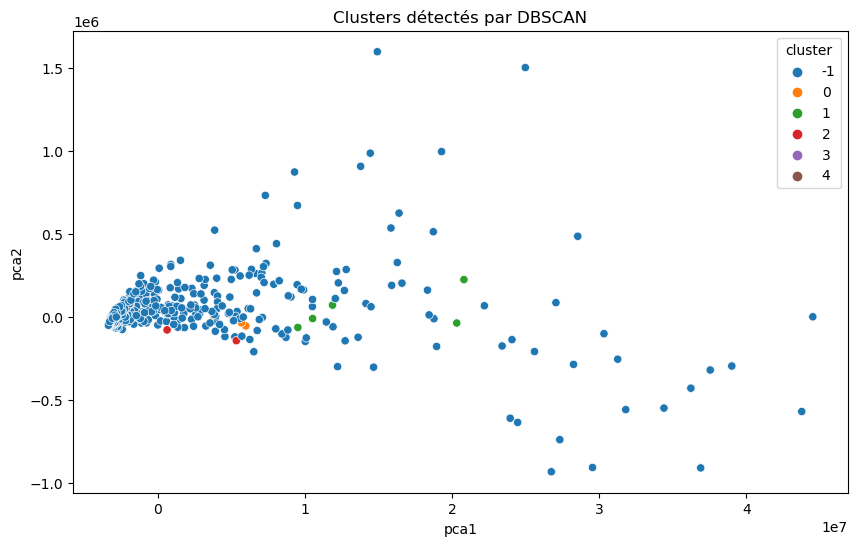

In [34]:
from sklearn.decomposition import PCA

# Réduction en 2D pour la visualisation
pca = PCA(n_components=2)
dataset_vect.fillna(0,  inplace=True)
X_pca = pca.fit_transform(dataset_vect)
dataset_vect['pca1'] = X_pca[:, 0]
dataset_vect['pca2'] = X_pca[:, 1]

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue=dataset_vect['cluster'], palette='tab10', data=dataset_vect)
plt.title("Clusters détectés par DBSCAN")
plt.show()

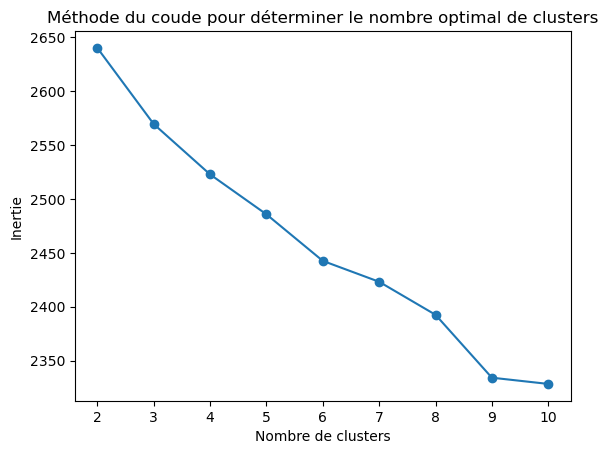

In [28]:
spotify.visualize_clustering(df=dataset_scaled, feature=dataset[['track_name']])

In [2]:
### Get a dataframe with last tracks
df = spotify.get_recent_tracks(10)

In [3]:
### Vectorize data from this dataframe
df_vect = spotify.vectorize_recent_tracks(df, n_components=3, played_date=False)

In [4]:
df_scaled = spotify.scale_and_weight(df_vect, weighted_features=['popularity', 'release_date', 'album_id', 'track_tags', 'track_artists_id'], weights=[2, 2, 3, 2, 3], n_components=3)

In [5]:
clusters = spotify.clustering(df_scaled)
df['cluster'] = clusters

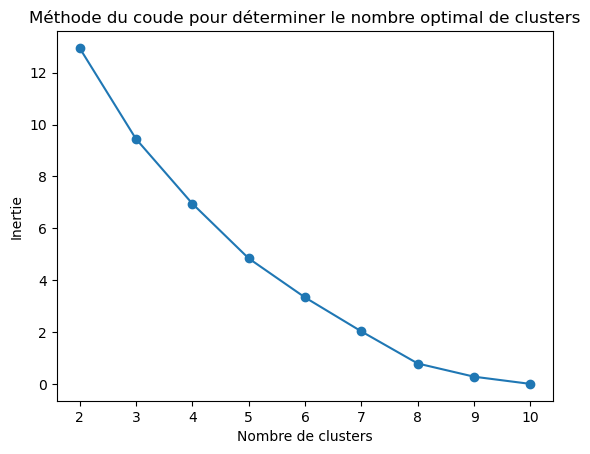

In [6]:
spotify.visualize_clustering(df=df_scaled, feature=df[['track_name']])

In [311]:
cluster_dfs = spotify.get_tracklist(df, limit=1)
cluster_vect_dfs = spotify.vectorize_tracklist(cluster_dfs, weighted_features=['popularity', 'release_date', 'album_id', 'track_tags', 'track_artists_id'], weights=[2, 2, 3, 2, 3], n_components=1)
cosine_matrices = spotify.compute_cosine_matrices(cluster_vect_dfs)

c:\Anaconda\lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [313]:
similar_tracks = spotify.search_similar_tracks_by_pos(df, cluster_dfs, cosine_matrices, track_pos=6)
similar_tracks

"Tracks similaires à 'Monaco' : Minimum ça, CIEL, Boucan (feat. Franglish), On y va, OHMA TOKITA"